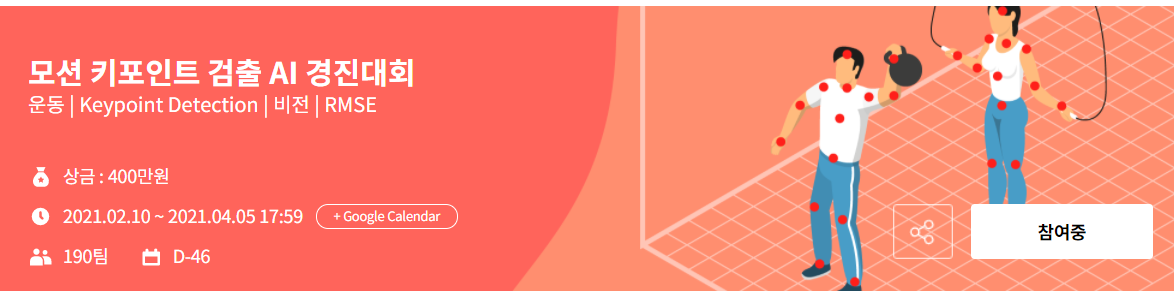

### [대회 설명]

		



- 본 대회는 특정 운동 동작을 수행하고 있는 사람의 미리 지정된 각 신체 부위의 위치에서 측정한 데이터를 활용하여 신체 동작 마다의 키포인트를 검출하는 대회입니다.
- 참가자 분들은 '데이터 연구소'에서 제작한 HumanFit human keypoint set을 활용해 운동 동작 사진을 보고 키포인트를 검출해주세요! 




### [주제 및 배경]





- Motion keypoint detection 알고리즘 개발
- 스마트 헬스케어 산업에 적용 가능한 데이터 분석 방법

### [데이터]





- HumanFit human keypoint set 
  - 신체 24개 부위에서 측정한 포인트  

  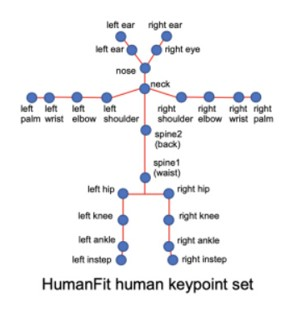



- train_imgs
  - train 이미지 4195장  

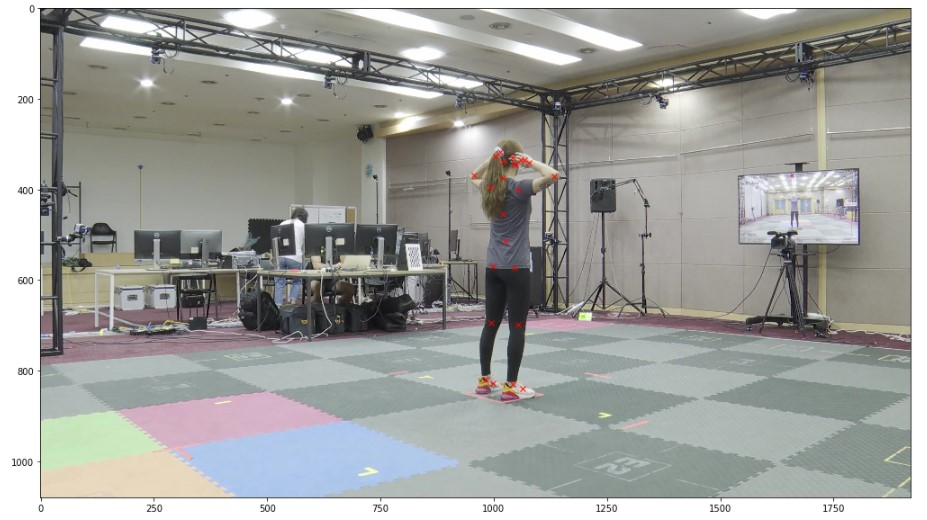




- test_imgs
  - test 이미지 1600장



- train_df (4195 *49)
  - train이미지의 이름과 keypoint 24 지점의 x,y 좌표



- sample_submission(1600 *49)
  - 정답지

In [ ]:
import tensorflow as tf
import cv2
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 초급 베이스 코드를 실행시켜보며 감 잡아보기

In [ ]:
#glob를 활용해 이미지의 경로들을 불러온다.
import glob
train_paths = glob.glob('./train_imgs/*.jpg')
test_paths = glob.glob('./test_imgs/*.jpg')

#### MODELING + MAKING DATASET
- 대용량 이미지를 불러올 때 Generator을 활용해서 불러온다.
- from_generator를 사용하면 한번에 데이터를 메모리에 다 로딩하는 것이 아니고, 필요할 때만 python generator를 통해서 데이터를 가져온다.
- python generator의 목적 자체가 무한한 데이터를 다루거나, 데이터를 필요할 때 가져오는 lazy loading을 위한 것이니 딱 맞음

In [ ]:
train['path'] = train_paths

def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(
    trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([48]))
    )
train_dataset = train_dataset.batch(32).prefetch(1) # prefetch를 해주면 더 빠른 속돌 데이터를 입력할 수 있다.(학습 속도가 올라감)

#### BUILD + TRAIN MODEL

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3))) # 가로길이 180, 세로길이 320, 차원의 수 3인 이미지데이터를 32의 batch size로 입력하게 된다.
# 따라서 데이터 전체의 shape로는 (32, 180, 320, 3)이 된다.
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

model.fit(train_dataset,epochs = 5, verbose=1)

#### VISUALIZATION

In [ ]:
# 방법 1. Matplotlib 사용
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [ ]:
# 방법 2. cv2 사용
def draw_keypoints(image: np.ndarray, keypoints: np.ndarray, edges: List[Tuple[int, int]]) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}
    x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
    x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        cv2.putText(
            image, 
            f'{i}: {keypoint_names[i]}', 
            tuple(keypoint), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    for i, edge in enumerate(edges):
        cv2.line(
            image, 
            tuple(keypoints[edge[0]]), 
            tuple(keypoints[edge[1]]),
            colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=200)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')

In [ ]:
# 데이터 시각화를 하나의 이미지를 불러와서 시도해 보자
keypoints = df.iloc[0, 1:].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = df.columns[1:].tolist()

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (11, 13), (13, 15), (12, 14), 
    (14, 16), (5, 6), (15, 22), (16, 23), (11, 21),
    (21, 12), (20, 21), (5, 20), (6, 20), (17, 6), (17, 5)
]

image = cv2.imread('./data/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
draw_keypoints(image, keypoints, edges)

#### PREDICT USING THE TEST DATA

In [ ]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

X_test=tf.stack(X_test, axis=0)
X_test.shape
TensorShape([1600, 180, 320, 3])

pred=model.predict(X_test)